Bollinger bands

Bollinger band definition from investopedia:
https://www.investopedia.com/terms/b/bollingerbands.asp

$$ BOLU = MA(TP, n) + m * \sigma(TP, n) $$   
$$ BOLU = MA(TP, n) - m * \sigma(TP, n) $$

MA ... Moving Average
TP (typical price) = (High + Low + Close) / 3
n = 
m = 
$\sigma(TP, n)$



In [212]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [213]:
# ___variables___
#ticker = 'AAPL'
#ticker = 'TSLA'
ticker = 'GOOGL'

start_time = datetime.datetime(2020, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today


In [214]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

connected to yahoo
        Date         High          Low         Open        Close   Volume    Adj Close
0 2020-01-02  1368.680054  1346.489990  1348.410034  1368.680054  1363900  1368.680054
1 2020-01-03  1373.750000  1347.319946  1348.000000  1361.520020  1170400  1361.520020
2 2020-01-06  1398.319946  1351.000000  1351.630005  1397.810059  2338400  1397.810059
3 2020-01-07  1403.500000  1391.560059  1400.459961  1395.109985  1716500  1395.109985
4 2020-01-08  1411.849976  1392.630005  1394.819946  1405.040039  1765700  1405.040039


In [215]:
df = ticker_df

In [216]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [217]:
def bollinger_bands(df, n, m):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [218]:
df = bollinger_bands(df, 20, 2)

In [219]:
print(df.head())
print(df.tail())

        Date         High          Low         Open        Close   Volume    Adj Close  B_MA  BU  BL
0 2020-01-02  1368.680054  1346.489990  1348.410034  1368.680054  1363900  1368.680054   NaN NaN NaN
1 2020-01-03  1373.750000  1347.319946  1348.000000  1361.520020  1170400  1361.520020   NaN NaN NaN
2 2020-01-06  1398.319946  1351.000000  1351.630005  1397.810059  2338400  1397.810059   NaN NaN NaN
3 2020-01-07  1403.500000  1391.560059  1400.459961  1395.109985  1716500  1395.109985   NaN NaN NaN
4 2020-01-08  1411.849976  1392.630005  1394.819946  1405.040039  1765700  1405.040039   NaN NaN NaN
          Date         High          Low         Open        Close   Volume    Adj Close         B_MA           BU           BL
191 2020-10-05  1484.699951  1460.089966  1462.650024  1482.829956  1080100  1482.829956  1481.185164  1565.365137  1397.005192
192 2020-10-06  1484.520020  1445.010010  1475.500000  1451.020020  1304800  1451.020020  1477.600165  1558.741365  1396.458964
193 2020-1

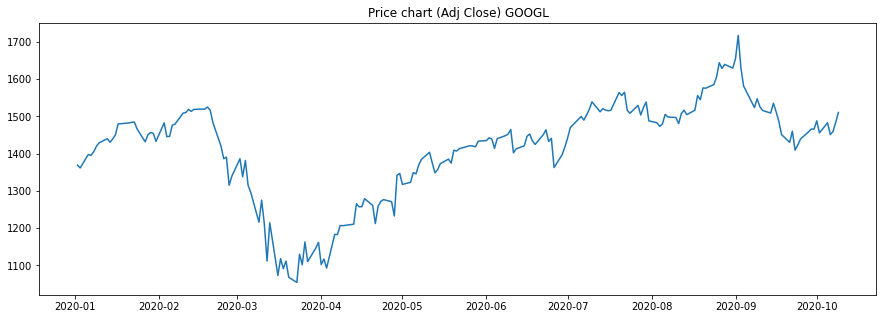

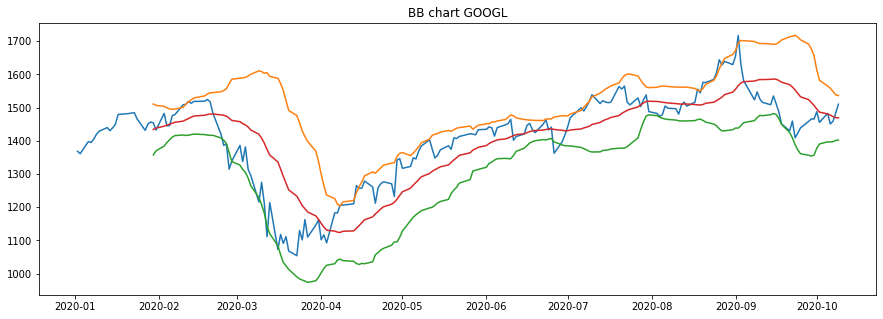

In [220]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()


# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('BB chart ' + str(ticker))
plt.plot(df['Date'], df['Adj Close'])
plt.plot(df['Date'], df['BU'])
plt.plot(df['Date'], df['BL'])
plt.plot(df['Date'], df['B_MA'])


plt.show()

#### Sources:
https://github.com/Crypto-toolbox/pandas-technical-indicators   <BR>
https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code  <BR>
https://www.investopedia.com/terms/b/bollingerbands.asp     <BR>